# IP3D Gains

**Question:** Why does including ip3d help the performance of the BDT even when rnnip is already included?


In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import h5py

import sys
sys.path.append("..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


### Step 1: Plot the roc curves for ip3d and rnnip

Since atm in this nb I only have the datasets with 1k jets of variables, I'm going to go ahead and start getting my plotting software up and running, and then tomorrow I can iterate!

In [27]:
# Load in the jets df, and make the roc curves for ip3d and rnnip
subDir = "mc16d_Topo_ttbar"
filepath = "../data/{}/".format(subDir)
data_tag = "3m_15trks_sd0_rev"

jet_df = pd.read_hdf('{}/jet_{}.h5'.format(filepath,data_tag), 
                     key='jet_df')
trk_xr = xr.open_dataarray('{}/trk_{}.nc'.format(filepath,data_tag))

In [4]:
jet_df.head()

LabDr_HadF    pt_orig  eta_orig  phi_orig          m  ip3d_llr   ip3d_pb  \
0         4.0  82.521891 -1.647832 -1.115594   7.076710  8.030893  0.070772   
1         4.0  72.872375  1.698972  2.003417   8.230029  3.700817  0.028174   
2         5.0  34.415184  2.089628 -0.551500   6.249995  5.713408  0.046954   
3        15.0  28.808963  1.997881  3.136153   4.981111 -1.069982  0.056802   
4         0.0  53.356875 -2.145085  2.970182  10.792096  1.418369  0.000938   

    ip3d_pc   ip3d_pu  ip3d_ntrk    ...      aliveAfterORmu        llr  \
0  0.002910  0.000023        4.0    ...                 1.0   6.596817   
1  0.010117  0.000696        4.0    ...                 1.0   2.755359   
2  0.003810  0.000155        4.0    ...                 1.0   1.964071   
3  0.125082  0.165595        2.0    ...                 1.0 -99.000000   
4  0.002009  0.000227        6.0    ...                 1.0 -99.000000   

        JVT         pt       eta  rnnip_pu  rnnip_pc  rnnip_pb  rnnip_ptau  \
0  0.998500  85.362094 -1.646813  0.017968  0.080970  0.895366    0.005695   
1  0.995474  65.487230  1.697786  0.128092  0.270342  0.586582    0.014983   
2  0.997876  35.314129  2.089185  0.002254  0.018693  0.978173    0.000880   
3  0.998573  25.361543  1.997358  0.632889  0.117815  0.063850    0.185446   
4  0.987650  55.109125 -2.144747  0.669229  0.171371  0.156907    0.002493   

      bH_Lxy  
0 -99.000000  
1 -99.000000  
2   6.741858  
3 -99.000000  
4 -99.000000  

[5 rows x 22 columns]

In [5]:
fc = 0.07

In [6]:
disc = jet_df.ip3d_pb / (fc*jet_df.ip3d_pc + (1-fc)*jet_df.ip3d_pu)

In [7]:
discMin, discMax = np.min(disc), np.max(disc)

In [8]:
for i,j in zip(jet_df.ip3d_llr[:10], disc):
    print(i,j)

8.030893325805664 314.4355658762005
3.7008166313171387 20.785725583833425
5.713408470153809 114.28582479309783
-1.0699824094772339 0.3489913327362815
1.4183688163757324 2.665713777347902
1.721672773361206 3.5221941074176093
-3.4301517009735107 0.03384506626979059
5.982407093048096 37.946129112710864
-6.845901966094971 0.0011366481855511115
5.622524738311768 128.17406797282632


Ok, clearly these variables are not the same thing... which gives better roc curves?

In [9]:
leffs = []
ceffs = []
beffs = []

In [10]:
discMax

inf

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


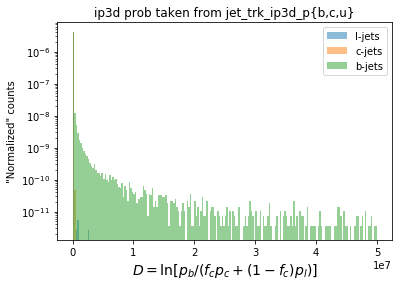

In [11]:
nBins = 200
myRange = (discMin,5e7)

for pdg, flav in zip([0,4,5],['l','c','b']):
    
    n,_,_ = plt.hist(disc.loc[jet_df.LabDr_HadF == pdg],
                     bins=nBins,range=myRange, 
                     label="{}-jets".format(flav),
                     alpha = 0.5,
                     normed=True, log=True) 
    
    # Calculate the eff
    eff = calculateEff(n)
    
    if pdg == 0:
        leffs.append(eff)
    elif pdg == 4:
        ceffs.append(eff)
    elif pdg == 5:
        beffs.append(eff)
        
plt.legend()
plt.xlabel('$D = \ln [ p_b / (f_c p_c + (1- f_c)p_l ) ]$',fontsize=14)
plt.ylabel('"Normalized" counts')
plt.title("ip3d prob taken from jet_trk_ip3d_p{b,c,u}")
plt.show()

../plottingFcts.py:431: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


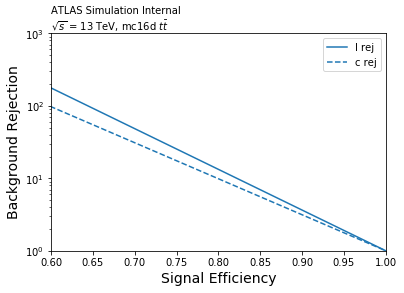

In [12]:
plotROC(beffs*2,leffs+ceffs, ['l rej','c rej'], 
        colors=['C0','C0'], styles=['-','--'])

Ok, this is *obviously* wrong, although I'm not sure why???

### Looking at the `ip3d_llr` variable

There was another variable in the df, so let's take a look to see what's inside it!

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


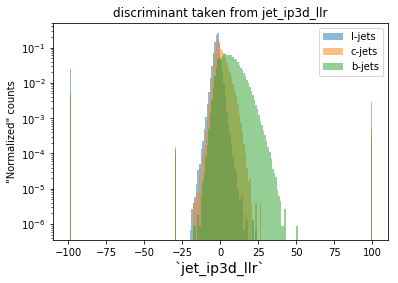

In [13]:
nBins = 200
myRange = (-100,100)

for pdg, flav in zip([0,4,5],['l','c','b']):
    
    n,_,_ = plt.hist(jet_df.ip3d_llr[jet_df.LabDr_HadF == pdg],
                     bins=nBins,range=myRange, 
                     label="{}-jets".format(flav),
                     alpha = 0.5,
                     normed=True, log=True) 
    
    # Calculate the eff
    eff = calculateEff(n)
    
    if pdg == 0:
        leffs.append(eff)
    elif pdg == 4:
        ceffs.append(eff)
    elif pdg == 5:
        beffs.append(eff)
        
plt.legend()
plt.xlabel('`jet_ip3d_llr`',fontsize=14)
plt.ylabel('"Normalized" counts')
plt.title("discriminant taken from jet_ip3d_llr")
plt.savefig("../figures/ip3d/disc_ip3d_llr.pdf")
plt.show()

In [14]:
jet_df[jet_df.ip3d_llr == -99].head()

LabDr_HadF    pt_orig  eta_orig  phi_orig         m  ip3d_llr  ip3d_pb  \
16          0.0  33.883523 -2.415142 -0.099903  2.863894     -99.0    -99.0   
47          0.0  23.941215  2.241839  0.450559  5.226969     -99.0    -99.0   
89          0.0  23.999748  2.409977  3.056923  5.338529     -99.0    -99.0   
131         0.0  25.005746 -0.015175 -0.469544  4.620395     -99.0    -99.0   
233         0.0  25.468209  0.959086 -2.807458  5.251690     -99.0    -99.0   

     ip3d_pc  ip3d_pu  ip3d_ntrk   ...    aliveAfterORmu   llr       JVT  \
16     -99.0    -99.0        0.0   ...               1.0 -99.0  0.000000   
47     -99.0    -99.0        0.0   ...               1.0 -99.0  0.693652   
89     -99.0    -99.0        0.0   ...               1.0 -99.0  0.200233   
131    -99.0    -99.0        0.0   ...               1.0 -99.0  0.722309   
233    -99.0    -99.0        0.0   ...               1.0 -99.0  0.989468   

            pt       eta  rnnip_pu  rnnip_pc  rnnip_pb  rnnip_ptau  bH_Lxy  
16   35.185594 -2.413852       0.0       0.0       0.0         0.0   -99.0  
47   24.372945  2.240020       0.0       0.0       0.0         0.0   -99.0  
89   25.532744  2.410885       0.0       0.0       0.0         0.0   -99.0  
131  24.789324 -0.016217       0.0       0.0       0.0         0.0   -99.0  
233  24.648486  0.960010       0.0       0.0       0.0         0.0   -99.0  

[5 rows x 22 columns]

All of these jets with the default value of -99 *don't have any tracks.*

In [15]:
jet_df[(jet_df.ip3d_llr == -99) & (jet_df.ip3d_ntrk != 0)].head()

Empty DataFrame
Columns: [LabDr_HadF, pt_orig, eta_orig, phi_orig, m, ip3d_llr, ip3d_pb, ip3d_pc, ip3d_pu, ip3d_ntrk, mv2c10, aliveAfterOR, aliveAfterORmu, llr, JVT, pt, eta, rnnip_pu, rnnip_pc, rnnip_pb, rnnip_ptau, bH_Lxy]
Index: []

[0 rows x 22 columns]

../plottingFcts.py:431: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


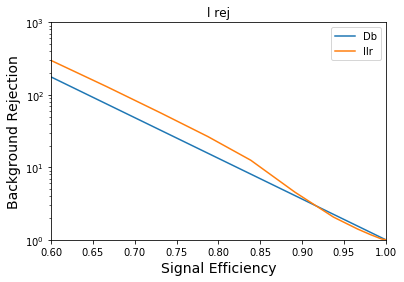

In [16]:
plotROC(beffs,leffs,['Db','llr'],title='l rej')

../plottingFcts.py:431: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


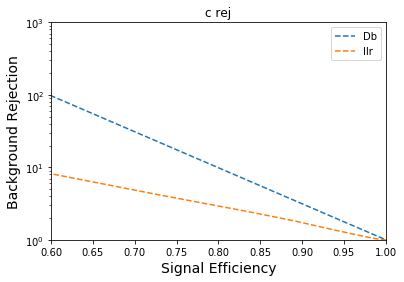

In [17]:
plotROC(beffs,ceffs,['Db','llr'],
        styles=['--','--'],
        title='c rej')

In [18]:
len(leffs)

2

In [19]:
len(leffs+ceffs)

4

Ok, so I know that Rafael already did this study, but I'm super interested to know what is stored inside of the pre-trained rnn probabilities.

In [20]:
rnn_disc = jet_df.rnnip_pb / (fc*jet_df.rnnip_pc + (1-fc)*jet_df.rnnip_pu)

In [21]:
rnnMin, rnnMax = np.min(rnn_disc), np.max(rnn_disc)

In [22]:
rnnMin,rnnMax

(0.0019578847026048125, 79955.29483026739)

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


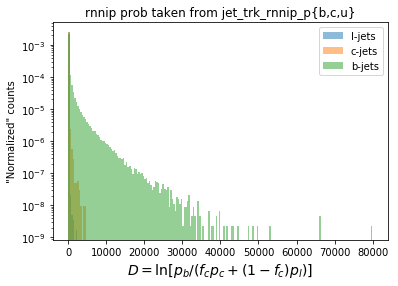

In [23]:
nBins = 200
myRange = (rnnMin,rnnMax)

for pdg, flav in zip([0,4,5],['l','c','b']):
    
    n,_,_ = plt.hist(rnn_disc.loc[jet_df.LabDr_HadF == pdg],
                     bins=nBins,range=myRange, 
                     label="{}-jets".format(flav),
                     alpha = 0.5,
                     normed=True, log=True) 
    
    # Calculate the eff
    eff = calculateEff(n)
    
    if pdg == 0:
        leffs.append(eff)
    elif pdg == 4:
        ceffs.append(eff)
    elif pdg == 5:
        beffs.append(eff)
        
plt.legend()
plt.xlabel('$D = \ln [ p_b / (f_c p_c + (1- f_c)p_l ) ]$',fontsize=14)
plt.ylabel('"Normalized" counts')
plt.title("rnnip prob taken from jet_trk_rnnip_p{b,c,u}")
plt.show()

../plottingFcts.py:431: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


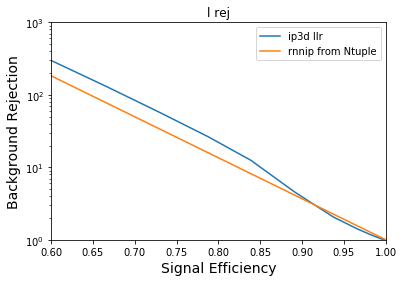

In [24]:
plotROC(beffs[1:],leffs[1:],
        ['ip3d llr','rnnip from Ntuple'],
        title='l rej',subDir="ip3d",tag="lrej_llr_vs_Ntuplernn")

Maybe I'm doing a little worse with this b/c it's a training on mc16a evaluated on mc16d?

../plottingFcts.py:431: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


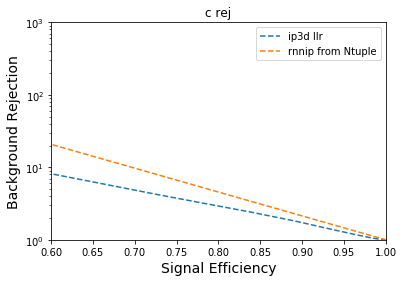

In [25]:
plotROC(beffs[1:],ceffs[1:],
        ['ip3d llr','rnnip from Ntuple'],
        styles=['--','--'],
        title='c rej',subDir="ip3d",tag="crej_llr_vs_Ntuplernn")

**Last roc comparison**:

Ok, I really want to be comparing the latest and greatest rnn, so I'm going to get the rnn that I trained and compare against *that* instead!

(Hopefully the roc curve will dominate like it did in the pub note!)

Initialize method from myModel()
Loading previously trained LSTM
LSTM_50units_10dense_3m_15trks_sd0_sz0_ptfrac_dr_hits_sd0_rev_logNorm_noEmbed


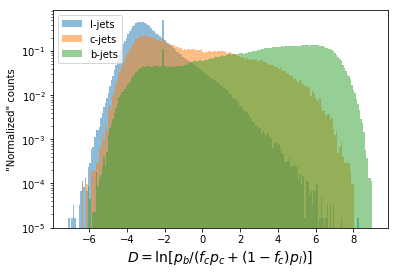

In [30]:
dataTag = "3m_15trks_sd0_sz0_ptfrac_dr_hits_sd0_rev_logNorm"

f = h5py.File("../data/{}/data_{}.hdf5".format(subDir,dataTag),"r")

X  = f['X_test'][:]
y  = f['y_test'][:]
ix = f['ix_test'][:]

f.close()

nJets, nTrks, nFeatures = X.shape

# Open the model
modelName = "LSTM_50units_10dense_{}_noEmbed".format(dataTag)
    
# Open the model
m = myLSTM(modelName=modelName, modelDir="../models/"+subDir,
           loadModel=load_model, doEmbedding=False)

print(m.modelName)

# Get the efficiencies
(l_eff, c_eff, b_eff), disc = sigBkgEff(m, X, y, ix, subDir=subDir, returnDisc=True)
 
leffs.append(l_eff)
ceffs.append(c_eff)
beffs.append(b_eff)

../plottingFcts.py:431: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


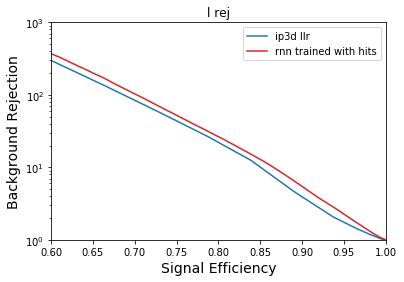

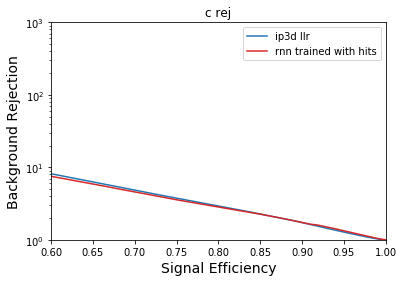

In [31]:
for bkg_effs, flav in zip([leffs, ceffs], ['l','c']):
    
    plotROC([beffs[1],beffs[-1]], 
            [bkg_effs[1],bkg_effs[-1]],
            ['ip3d llr','rnn trained with hits'],
            colors=['C0','C3'],
            title='{} rej'.format(flav), subDir="ip3d",
            tag="{}rej_llr_vs_hitsRnn".format(flav))

## Comparison between what the algs are learning

Look at the scatter plot between the $D_b$ from the RNN and the LLR for ip3d to get a visual intuition for what jets are more efficiently tagged by one alg versus the other!

Ideas: 
- I could color code this plot to correspond to the different jet flavors.
- Could add dashed lines for the 70% WPs.


In [32]:
# Get the ip3d 70%WP
WP = .70
ip3d_70WP = workingPoint(jet_df.ip3d_llr[jet_df.LabDr_HadF == 5],
                         1000, (-100,100), WP=WP)

# Get the rnnip 70% WP
rnn_70WP = workingPoint(disc[y==2], 200,(np.min(disc),np.max(disc)),WP=WP)


i_eff = 487, teff = 0.7060273644884023
Cut on discriminant at 2.4000000000000057
i_eff = 93, teff = 0.7018389152350352
Cut on discriminant at 1.4354820251464844


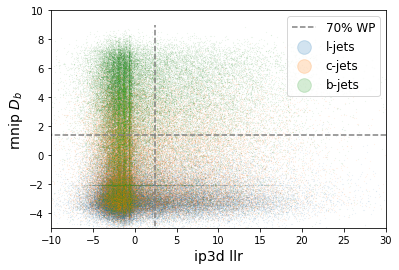

In [33]:
llr = jet_df.loc[ix,'ip3d_llr']

# Sometimes it's hard to see what the plot is trying to show
# when I'm displying so many points, so try just showing a fixed
# number of jets for each flavor.
nJets = 50000 

for yi, flav in enumerate(['l','c','b']):
    
    
    mask = (y == yi)
    c = "C{}".format(yi)
    
    plt.scatter(llr[mask][:nJets], disc[mask][:nJets], s=1e-1, color=c, marker='.', 
                alpha=0.2, label='{}-jets'.format(flav))
    
    
# Add the WPs
plt.plot([ip3d_70WP]*2, [np.min(disc),np.max(disc)],
         color='grey',linestyle='--',label='70% WP')
plt.plot([np.min(llr),np.max(llr)], [rnn_70WP]*2, 
         color='grey',linestyle='--')
    
lgnd = plt.legend(fontsize=12)

# Make the legend markers large enough so that you can see it!
for handle in lgnd.legendHandles[1:]:
    handle.set_sizes([750])

plt.xlim(-10,30)
plt.ylim(-5,10)
plt.xlabel('ip3d llr',fontsize=14)
plt.ylabel('rnnip $D_b$',fontsize=14)
plt.savefig('../figures/ip3d/Db_vs_llr.png')
plt.show()

Ok, so there are clearly some differences in the classification decisions between these two algorithms. But the ip3d uses as it's discriminant one comparable to the one for ip3d, except with $f_c = 0$. So I wonder if we'll see the rnn discriminant outperforming the ip3d discriminant if we use $f_c = 0$ in it's definition as well? (Or at least, it's worth a quick try!) 

FileNotFoundError: [Errno 2] No such file or directory: '../figures/mc16d/disc_LSTM_50units_10dense_3m_15trks_sd0_sz0_ptfrac_dr_hits_sd0_rev_logNorm_noEmbedfc_0.pdf'

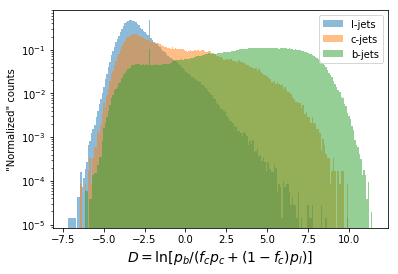

In [34]:
(l_eff, c_eff, b_eff), disc_fc0 = sigBkgEff(m, X, y, ix, returnDisc=True,
                                        tag="fc_0",fc=0)

In [ ]:
# Get the new rnnip 70% WP
rnn_fc0_70WP = workingPoint(disc_fc0[y==2], 200,(np.min(disc_fc0),np.max(disc_fc0)),WP=WP)

In [ ]:
llr = jet_df.loc[ix,'ip3d_llr']

# Sometimes it's hard to see what the plot is trying to show
# when I'm displying so many points, so try just showing a fixed
# number of jets for each flavor.
nJets = 50000 

for yi, flav in enumerate(['l','c','b']):
    
    mask = (y == yi)
    c = "C{}".format(yi)
    
    plt.scatter(llr[mask][:nJets], disc_fc0[mask][:nJets], s=1e-1, color=c, marker='.', 
                alpha=0.2, label='{}-jets'.format(flav))
    
    
# Add the WPs
plt.plot([ip3d_70WP]*2, [np.min(disc_fc0),np.max(disc_fc0)],
         color='grey',linestyle='--',label='70% WP')
plt.plot([np.min(llr),np.max(llr)], [rnn_fc0_70WP]*2, 
         color='grey',linestyle='--')
    
lgnd = plt.legend(fontsize=12)

# Make the legend markers large enough so that you can see it!
for handle in lgnd.legendHandles[1:]:
    handle.set_sizes([750])

plt.xlim(-10,30)
plt.ylim(-5,10)
plt.xlabel('ip3d llr',fontsize=14)
plt.ylabel('rnnip $D_b$',fontsize=14)
plt.title('rnnip $D_b$ with $f_c$ = 0')
plt.savefig('../figures/ip3d/Db_vs_llr_fc_0.png')
plt.show()

Visually, they *don't* look that different, but it might be worthwhile to go ahead and calculate the efficiencies that i was looking at before, to see if this improves the rnn's comparative l-rej performance.

### Q1: If ip3d succeeded, how often does rnnip fail?

**If ip3d successfully classified a b-jet, how often does rnnip fail?**

In [ ]:
den_mask = (y == 2) & (llr > ip3d_70WP)
num_mask = den_mask & (disc_fc0 < rnn_fc0_70WP)

100 * np.sum(num_mask) / np.sum(den_mask)

**If ip3d successfully classified a l-jet, how often does rnnip fail?**

In [ ]:
den_mask = (y == 0) & (llr < ip3d_70WP)
num_mask = den_mask & (disc_fc0 > rnn_fc0_70WP)

100 * np.sum(num_mask) / np.sum(den_mask)

### Q2: If rnnip succeeded, how often does ip3d fail?

**If rnnip successfully classified a b-jet, how often does ip3d fail?**

In [ ]:
den_mask = (y == 2) & (disc_fc0 > rnn_fc0_70WP)
num_mask = den_mask & (llr < ip3d_70WP)

100 * np.sum(num_mask) / np.sum(den_mask)

**If rnnip successfully classified a l-jet, how often does ip3d fail?**

In [ ]:
den_mask = (y == 0) & (disc_fc0 < rnn_fc0_70WP)
num_mask = den_mask & (llr > ip3d_70WP)

100 * np.sum(num_mask) / np.sum(den_mask)

### Step 2: Some intuition plots

From [ATL-PHYS-PUB-2017-013](http://cdsweb.cern.ch/record/2273281/files/ATL-PHYS-PUB-2017-013.pdf):


    Decays with low track multiplicity and with short decay distances, within the radius of the innermost pixel layer, are efficently tagged by IP3D. Decays with higher multiplicity and those with longer decay distances are more efficiently tagged by RNNIP.


Michael suggested that I look into these studies by investigating the distributions of
- $n_{trk}$
- $L_{xy}$
for *correctly* and *incorrectly* IDed jets at the 70% WP to uncover if there's a distributional dependence in the jets that are correctly IDed by each alg.

Rafael said another way that I could probe the effect would be to plot the roc curve in bins of $n_{trk}$, similar to what he did to study the dependence of the alg on the PU profile.

Furthermore, he said that since $L_{xy}$ is related to the boost of the jet (and more energetic jets tend to have more tracks) it would be a good idea to look at the $p_T$ dependence for *each* of these algs at the 70% WP for the $\epsilon_b$, $1/\epsilon_l$, and $1/\epsilon_c$.


Notes: 
- Before I was looking at the 77% WP, but maybe these depndencies will be more clear when I look at the 70% WP? 
- Idk, but something to consider.
- Maybe I could also make tables of the l and c rejections for each of the algorithms for all of the supported b-tagging working points?


In [ ]:
jet_df.columns

Rafael told me that it was faster to use the weights for the histogram instead of using the .loc to access the variables.

In [ ]:
nBins = 16
myRange = (-0.5,15.5)

# Try comparing the normalized with the unnormalized distributions
for density, normTag in zip([True, False],['','_noNorm']):
    
    for pdg, flav in zip([0,4,5],['l','c','b']):

        plt.figure()

        mask = (jet_df.loc[ix,'LabDr_HadF'] == pdg)


        for d, alg ,cut, color in zip([jet_df.loc[ix,'ip3d_llr'], disc], 
                               ['ip3d','rnn'], [ip3d_70WP, rnn_70WP], ['C0','C3']):

            if pdg == 5:
                wrong   = mask & (d < cut)
                correct = mask & (d > cut)

            else:
                wrong   = mask & (d > cut)
                correct = mask & (d < cut)

            plt.hist(jet_df.loc[ix,'ip3d_ntrk'][wrong], color=color, linestyle='--',
                     density=density, bins=nBins, range=myRange, 
                     histtype="step",label='{}: incorrect tag'.format(alg))

            plt.hist(jet_df.loc[ix,'ip3d_ntrk'][correct], color=color, linestyle='-',
                     density=density, bins=nBins, range=myRange, 
                     histtype="step",label='{} jets: correct tag'.format(alg))

        plt.title('{}-jets: {}% WP'.format(flav, WP*100))
        plt.legend()
        plt.xlabel("$n_{trk}^{IP3D}$",fontsize=18)
        plt.savefig('../figures/ip3d/nTrks_{}jets{}.pdf'.format(flav,normTag),bbox_inches='tight')
        plt.show()

Ok, so this distribution of b-jets definitely seems to *confirm* the statement from the pub note.


For $L_{xy}$, since I'm plotting this for the truth b-hadron, I only expect an $L_{xy}$s for the truth b-hadrons (except fringe mislabeling cases). So, I'm only going to plot this distribution for truth b-jets. 

In [ ]:
WPs = [.6, .7, .77, .85]

ip3d_cuts = []
rnn_cuts = []

for WP in WPs:

    print('Getting cuts for the {}% WP'.format(WP*100))
    ip3d_cuts.append( workingPoint(jet_df.ip3d_llr[jet_df.LabDr_HadF == 5],
                                   1000, (-100,100), WP=WP) )

    rnn_cuts.append( workingPoint(disc[y==2], 200,(np.min(disc),np.max(disc)),WP=WP) )


In [ ]:
nBins = 25 
myRange = range=(0,nBins)

pdg=5
flav='b'

i_loc = 1
WP, ip3d_cut, rnn_cut = WPs[i_loc], ip3d_cuts[i_loc], rnn_cuts[i_loc]

# Try comparing the normalized with the unnormalized distributions
for density, normTag in zip([True, False],['','_noNorm']):

    for log, logTag in zip([False,True],['','_log']):
    
        plt.figure()

        mask = (jet_df.loc[ix,'LabDr_HadF'] == pdg)

        for d, alg ,cut, color in zip([jet_df.loc[ix,'ip3d_llr'], disc], 
                                      ['ip3d','rnn'], [ip3d_cut, rnn_cut], ['C0','C3']):


            wrong   = mask & (d < cut)
            correct = mask & (d > cut)


            plt.hist(jet_df.loc[ix,'bH_Lxy'][wrong], color=color, linestyle='--',
                     density=density, bins=nBins, range=myRange, log=log,
                     histtype="step",label='{}: incorrect tag'.format(alg))

            plt.hist(jet_df.loc[ix,'bH_Lxy'][correct], color=color, linestyle='-',
                     density=density, bins=nBins, range=myRange, log=log,
                     histtype="step",label='{} jets: correct tag'.format(alg))


        plt.legend()
        plt.xlabel("b-hadron $L_{xy}$ [mm]",fontsize=14)
        plt.title('{}-jets: {}% WP'.format(flav, WP*100))

        plt.savefig('../figures/ip3d/bH_Lxy_{}jets{}{}_{:d}WP.pdf'.format(flav,normTag,logTag,int(WP*100)),bbox_inches='tight')
        plt.show()

Make a 2d histogram (or scatter plot) of ip3d_llr vs. b-hadron $L_{xy}$.

Again just consider b-jets.

In [ ]:
from matplotlib.colors import LogNorm

plt.hist2d(jet_df.loc[(jet_df.LabDr_HadF==pdg),'bH_Lxy'],
           jet_df.loc[(jet_df.LabDr_HadF==pdg),'ip3d_llr'],
           bins=nBins,range=[myRange,(-10,30)],
           cmap='Blues',norm=LogNorm())

plt.colorbar()

plt.xlabel("b-hadron $L_{xy}$ [mm]",fontsize=14)
plt.ylabel('ip3d llr',fontsize=14)
plt.title('b-jets')

plt.savefig('../figures/ip3d/ip3d_llr_vs_bH_Lxy_{}jets.pdf'.format(flav),bbox_inches='tight')

for ip3d_cut in ip3d_cuts:
    plt.plot(myRange,[ip3d_cut]*2,'k--')

plt.savefig('../figures/ip3d/ip3d_llr_vs_bH_Lxy_{}jets_WPs.pdf'.format(flav),bbox_inches='tight')    
plt.show()

Rafael told me that I should look into the $p_T$ dependence of *both* of these algs for the l and c-rej and the b-ef

In [ ]:
pts = jet_df.loc[ix,'pt']

ip3d_disc = jet_df.loc[ix,'ip3d_llr']

In [ ]:
plotPtDependence(pts, y,[ip3d_disc, disc],['ip3d','rnn'],
                 colors=['C0','C3'],subDir='ip3d',tag='hits_rnn')

- Ok, so I feel like this is saying to me that the rnn is always doing better than ip3d.
- However, I'm quite confused why these curves seem to be doing quite a bit worse than the pub note results
- And I don't understand the *shape* of IP3D.

The curves that I'm comparing against in the pub note were also looking at the 70% WP, so I should be comparing apples to apples here!


**Last exploratory plot:**
- Look at the l and c-rej roc curves in *bins* of $n_{trk}$.
- For now, just consider 5 different track multiplicity bins.

In [ ]:
trk_edges = np.arange(0.5, 18.5, 3)

ntrk_leffs = []
ntrk_ceffs = []
ntrk_beffs = []
ntrk_labels = []

for trk_min, trk_max in zip(trk_edges[:-1], trk_edges[1:]):

    mask = (jet_df.loc[ix,'ip3d_ntrk'] > trk_min) & (jet_df.loc[ix,'ip3d_ntrk'].values < trk_max)

    intMin = int(trk_min+0.5)
    intMax = int(trk_max-0.5)

    Xi = np.copy(X[mask])
    yi = np.copy(y[mask])

    l_eff, c_eff, b_eff = sigBkgEff(m, Xi, yi, subDir='ip3d',
                                    tag='nTrk_{}_{}'.format(intMin,intMax))
    label = str(intMin) + '$\leq n_{trk} \leq$'  + str(intMax)


    ntrk_leffs.append(l_eff)
    ntrk_ceffs.append(c_eff)
    ntrk_beffs.append(b_eff)
    ntrk_labels.append(label)
        

In [ ]:
plotROC(ntrk_beffs, ntrk_leffs, ntrk_labels, title='l rej: hits rnn',ymax=1e4,
        subDir='ip3d',tag='lrej_hits_rnn_nTrks')

In [ ]:
plotROC(ntrk_beffs, ntrk_ceffs, ntrk_labels, title='c rej: hits rnn',ymax=1e2,
        subDir='ip3d',tag='crej_hits_rnn_nTrks')

In [ ]:
nBins=1000
myRange=(-100,100)

ntrk_leffs = []
ntrk_ceffs = []
ntrk_beffs = []
ntrk_labels = []

for trk_min, trk_max in zip(trk_edges[:-1], trk_edges[1:]):

    mask = (jet_df.ip3d_ntrk > trk_min) & (jet_df.ip3d_ntrk < trk_max)

    intMin = int(trk_min+0.5)
    intMax = int(trk_max-0.5)

    label = str(intMin) + '$\leq n_{trk} \leq$'  + str(intMax)
    ntrk_labels.append(label)
    
    plt.figure()
    for pdg, flav in zip([0,4,5],['l','c','b']):

        n,_,_ = plt.hist(jet_df.ip3d_llr[mask & (jet_df.LabDr_HadF == pdg)],
                         bins=nBins,range=myRange, 
                         label="{}-jets".format(flav),
                         alpha = 0.5, density=True, log=True) 
    
        
        # Calculate the eff
        eff = calculateEff(n)
      
        if pdg == 0:
            ntrk_leffs.append(eff)
        elif pdg == 4:
            ntrk_ceffs.append(eff)
        elif pdg == 5:
            ntrk_beffs.append(eff)
    
    plt.legend()
    plt.xlabel('ip3d llr', fontsize=12)
    plt.title(label)
    plt.show()

In [ ]:
plotROC(ntrk_beffs, ntrk_leffs, ntrk_labels, title='l rej: ip3d',ymax=1e4,
        subDir='ip3d',tag='lrej_ip3d_nTrks')

In [ ]:
plotROC(ntrk_beffs, ntrk_ceffs, ntrk_labels, title='c rej: ip3d',ymax=1e2,
        subDir='ip3d',tag='crej_ip3d_nTrks')

**Update from talking with Michael:**

To correctly compare with the performance from the Run 2 pub note, I should be looking at the b-tagging performance for a *flat* efficiency.

**Important thing to note:**
- The bins need to be small enough such that the efficiency actually *is* flat across the $p_T$ range.


In [ ]:
plt.hist(pts[y==2],bins=20,range=(0,1000), log=True)
plt.xlabel('jet $p_T$ [GeV]')
plt.show()

In [ ]:
eff_bins = np.array([20,30,40,50,70,90,120,150,200,250,300,400,500,1000])

In [ ]:
len(eff_bins)

In [ ]:
indices = np.digitize(pts,bins=eff_bins)

In [ ]:
np.min(indices),np.max(indices)

In [ ]:
disc_range = (np.min(disc),np.max(disc))

Ok, so since eff_bins has 14 entries, there are 13 bins, so bin 0 is underflow and bin 14 is overflow.

In [ ]:
cut70_flat = np.array([workingPoint(disc[(y==2) & (indices==i)],200,disc_range) 
                       for i in np.arange(1,len(eff_bins))])

In [ ]:
((pts<30)&(y==2)).sum()

In [ ]:
yi = 2

sig_eff1 = np.zeros(cut70_flat.shape)
sig_eff2 = np.zeros(cut70_flat.shape[0]*2)

for i, pt_min, pt_max, cut in zip(np.arange(eff_bins.shape[0]), 
                               eff_bins[:-1],
                               eff_bins[1:],
                               cut70_flat):
    
    den_mask = (pts > pt_min) & (pts < pt_max) & (y == yi)
    num_mask = den_mask & (disc > cut)
    sig_eff1[i] = num_mask.sum() / den_mask.sum()
    
    pt_mid = .5 * (pt_min + pt_max)
    
    den1_mask = (pts > pt_min) & (pts < pt_mid) & (y == yi)
    num1_mask = den_mask & (disc > cut)
    sig_eff2[i*2] = num_mask.sum() / den_mask.sum()
    
    den2_mask = (pts > pt_mid) & (pts < pt_max) & (y == yi)
    num2_mask = den_mask & (disc > cut)
    sig_eff2[i*2+1] = num_mask.sum() / den_mask.sum()

In [ ]:
midpts1 = .5 * (eff_bins[:-1]+eff_bins[1:])

In [ ]:
midpts1.shape

In [ ]:
eff_bins2 = np.sort(np.concatenate((eff_bins,midpts1),axis=0))
midpts2 = .5 * (eff_bins2[:-1]+eff_bins2[1:])

In [ ]:
plt.scatter(midpts1,sig_eff1,label='Eff at 70% WP')
plt.scatter(midpts2,sig_eff2,label='Eff at 70% WP: smaller bins')
plt.ylim(0,1)
plt.legend()
plt.show()

Conclusion: I think the bins are small enough now!!

In [ ]:
plotPtDependence(pts, y,[ip3d_disc, disc],['ip3d','rnn'],flat=True,
                 colors=['C0','C3'],subDir='ip3d',tag='hits_rnn')

In [ ]:
cut70_flat.shape

In [ ]:
indices.min(), indices.max()

Below shows my work when I first started looking into this problem.
However, it didn't yeild super clear results, and takes a long time to run - that's why I moved these studies to the *end* of the notebook.


**Plan:** Add two new columns to the df:
- ip3d_77WP_tag
- rnn_77WP_tag

which are boolean variables which are `True` if this jet is above the discriminant threshold.

What I tried to do before to gain some more intuition about the problem was to plot the light and charm rejection at the 77% WP as a function of
- $n_{trk}^{IP3D}$
- $L_{xy}$

In [ ]:
# I needed to use more bins for the ip3d discriminant b/c I 
# didn't know what

ip3d_77WP = workingPoint(jet_df.ip3d_llr[jet_df.LabDr_HadF == 5],
                         1000,(-100,100),WP=.77)

In [ ]:
jet_df['ip3d_77WP_tag'] = (jet_df.ip3d_llr > ip3d_77WP)

In [ ]:
rnn_77WP = workingPoint(disc[y==2], nBins,
                        (np.min(disc),np.max(disc)),WP=.77)

In [ ]:
# Plan: Initialize rnn_77WP_tag to NaNs, and then fill in the tags
# for the test set where you have the discriminant calculated
jet_df['rnn_77WP_tag'] = pd.Series()


jet_df.loc[ix,'rnn_77WP_tag'] = (disc > rnn_77WP)


In [ ]:
jet_df.head()

In [ ]:
for c in jet_df.columns:
    print(c)

Ok, so $L_{xy}$ is *not* in the df atm, so I'm going to have to reprocess root_to_np now, and this time I might go ahead and do that for 5m jets to see if this improves my training performance.

I can always train the sample that I made w/ 5m jets on a subset since I put this functionality in `trainNet.py`.

In [ ]:
for pdg, flav in zip([0,4,5],['l','c','b']):

    plt.hist(jet_df.loc[(jet_df.LabDr_HadF==pdg),'ip3d_ntrk'], 
             bins=16, range=(-0.5,15.5), density=True,
             histtype="step",label='{} jets'.format(flav))
    
plt.legend(fontsize=12)
plt.xlabel("$n_{trk}^{IP3D}$",fontsize=18)
plt.show()

In [ ]:
nTrks = np.arange(16)

$$\varepsilon_b  = \frac{\text{# b-jets with } D_b > cut_{77\%}}{ \text{# b-jets}}$$

In [ ]:
# Let's start off by getting the curves for ip3d!

beff_ip3d = []
beff_rnn = []

for i in nTrks:
    
    # ip3d: since the llr was in the Ntuple, I can calculate this
    #       eff using all of the jets 
    den1_mask = (jet_df.LabDr_HadF == 5) & (jet_df.ip3d_ntrk == i)
    num1_mask = den1_mask & jet_df.ip3d_77WP_tag
    beff_ip3d.append( np.sum(num1_mask) / np.sum(den1_mask) )

    # rnn: here I only have the discriminant for the test set
    den2_mask = (jet_df.loc[ix,'LabDr_HadF'] == 5) & (jet_df.loc[ix,'ip3d_ntrk'] == i)
    num2_mask = den2_mask & jet_df.loc[ix,'ip3d_77WP_tag']
    beff_rnn.append( np.sum(num2_mask) / np.sum(den2_mask) )
    
    print('{:2d} trks: b eff ip3d = {:.2f}, rnn = {:.2f}'.format(i, beff_ip3d[i], beff_rnn[i]))

In [ ]:
plt.plot(nTrks,beff_ip3d,'C0.',label='ip3d')
plt.plot(nTrks,beff_rnn, 'C3.',label='rnn')

plt.legend(fontsize=12)
plt.xlabel("$n_{trk}^{IP3D}$",fontsize=18)
plt.ylabel("$\epsilon_b$",fontsize=18)
plt.tight_layout()
plt.savefig("../figures/ip3d/beff_vs_nTrks.pdf")
plt.show()

In [ ]:
# Let's start off by getting the curves for ip3d!

lrej_ip3d = []
lrej_rnn  = []

crej_ip3d = []
crej_rnn  = []

for i in nTrks:
    
    # l-rej: ip3d
    den1_mask = (jet_df.LabDr_HadF == 0) & (jet_df.ip3d_ntrk == i)
    num1_mask = den1_mask & jet_df.ip3d_77WP_tag
    # Do den / num since the rej is 1/eff
    lrej_ip3d.append( np.sum(den1_mask) /np.sum(num1_mask)  )

    # l-rej: rnn
    den2_mask = (jet_df.loc[ix,'LabDr_HadF'] == 0) & (jet_df.loc[ix,'ip3d_ntrk'] == i)
    num2_mask = den2_mask & jet_df.loc[ix,'ip3d_77WP_tag']
    lrej_rnn.append( np.sum(den2_mask) /np.sum(num2_mask) )
    
    # c-rej: ip3d
    den1_mask = (jet_df.LabDr_HadF == 4) & (jet_df.ip3d_ntrk == i)
    num1_mask = den1_mask & jet_df.ip3d_77WP_tag
    crej_ip3d.append( np.sum(den1_mask) /np.sum(num1_mask) )

    # c-rej: rnn
    den2_mask = (jet_df.loc[ix,'LabDr_HadF'] == 4) & (jet_df.loc[ix,'ip3d_ntrk'] == i)
    num2_mask = den2_mask & jet_df.loc[ix,'ip3d_77WP_tag']
    crej_rnn.append( np.sum(den2_mask) /np.sum(num2_mask) )
    

In [ ]:
plt.plot(nTrks,lrej_ip3d,'C0.',label='ip3d')
plt.plot(nTrks,lrej_rnn, 'C3',label='rnn')

plt.legend(fontsize=12)
plt.xlabel("$n_{trk}^{IP3D}$",fontsize=18)
plt.ylabel("1 / $\epsilon_l$",fontsize=18)
plt.tight_layout()
plt.savefig("../figures/ip3d/lrej_vs_nTrks.pdf")
plt.show()

In [ ]:
plt.plot(nTrks,crej_ip3d,'C0.',label='ip3d')
plt.plot(nTrks,crej_rnn, 'C3.',label='rnn')

plt.legend(fontsize=12)
plt.xlabel("$n_{trk}^{IP3D}$",fontsize=18)
plt.ylabel("1 / $\epsilon_c$",fontsize=18)
plt.tight_layout()
plt.savefig("../figures/ip3d/crej_vs_nTrks.pdf")
plt.show()

Ok, there's like *no* dependence on the 

### Step 3: IP3D successes

**Goal:** Find the set of jets that were *correctly* IDed by ip3d that were misclassified by rnnip.

This breaks down into *two* cases:

1. Cases where ip3d *correctly ided b-jets*

2. Cases where ip3d *correcly rejected background*
    - For simplicity, for this case, I'm going to restrict my study to l-jet background.
    
I think my best metrics here are just going to be first off, calculating the rate for *how often* this happens, and then plotting some distributions for the inputs to these algorithms, i.e, 
- $n_{trks}$
- $s_{d0}$ and $s_{z0}$
- Maybe $s_{d0}$ and $s_{z0}$ for the leading track?
    

#### 3a: IP3D correctly IDing b-jets

In [ ]:
mask1 = (jet_df.loc[ix,'LabDr_HadF'] == 5) & \
       (jet_df.loc[ix,'ip3d_77WP_tag']==True) & \
       (jet_df.loc[ix,'rnn_77WP_tag']==False)

np.sum( mask1 )

In [ ]:
mask2 = (jet_df.loc[ix,'LabDr_HadF'] == 5) & jet_df.loc[ix,'ip3d_77WP_tag'] 

np.sum( mask2 )

In [ ]:
100 * np.sum( mask1 ) / np.sum( mask2 )

Ok, so this only happens for 4.4% of the jets... that's actually rather high!

In [ ]:
nBins=26
myRange=(-0.5,25.5)

plt.hist(jet_df.loc[ix,'ip3d_ntrk'][(jet_df.loc[ix,'LabDr_HadF'] == 5) & jet_df.loc[ix,'ip3d_77WP_tag']],
         label='b-jets: IDed by ip3d',
         histtype="step", density=True,bins=nBins,range=myRange)


plt.hist(jet_df.loc[ix,'ip3d_ntrk'][(jet_df.loc[ix,'LabDr_HadF'] == 5) & jet_df.loc[ix,'rnn_77WP_tag']],
         label='b-jets: IDed by rnn',
         histtype="step", density=True,bins=nBins,range=myRange)


plt.hist(jet_df.loc[ix,'ip3d_ntrk'][mask],
         label='b-jets: IDed by ip3d, misclassified by rnn',
         histtype="step", density=True,bins=nBins,range=myRange)
plt.xlabel("$n_{trk}^{IP3D}$",fontsize=18)
plt.legend()

plt.tight_layout()
plt.savefig("../figures/ip3d/bjet_nTrks_rnnMistakes.pdf")

plt.show()

Ok, so this plot is *great* support for the claim in the pub note, I must have been looking at it wrong before??

In [ ]:
# nBins=26
# myRange=(-0.5,25.5)

# plt.hist(trk_xr.loc[:,:,'sd0'][ix],#[(jet_df.loc[ix,'LabDr_HadF'] == 5) & jet_df.loc[ix,'ip3d_77WP_tag']],
#          label='b-jets: IDed by ip3d',
#          histtype="step", density=True,bins=nBins,range=myRange)


# # plt.hist(jet_df.loc[ix,'ip3d_ntrk'][(jet_df.loc[ix,'LabDr_HadF'] == 5) & jet_df.loc[ix,'rnn_77WP_tag']],
# #          label='b-jets: IDed by rnn',
# #          histtype="step", density=True,bins=nBins,range=myRange)


# # plt.hist(jet_df.loc[ix,'ip3d_ntrk'][mask],
# #          label='b-jets: IDed by ip3d, misclassified by rnn',
# #          histtype="step", density=True,bins=nBins,range=myRange)
# # plt.xlabel("$n_{trk}^{IP3D}$",fontsize=18)
# # plt.legend()

# # plt.tight_layout()
# # plt.savefig("../figures/ip3d/bjet_nTrks_rnnMistakes.pdf")

# plt.show()

#### 3b: IP3D correctly rejecting l-jet background

In [ ]:
mask1 = (jet_df.loc[ix,'LabDr_HadF'] == 0) & \
       (jet_df.loc[ix,'ip3d_77WP_tag']==False) & \
       (jet_df.loc[ix,'rnn_77WP_tag']==True)

mask2 = (jet_df.loc[ix,'LabDr_HadF'] == 0) & \
        (jet_df.loc[ix,'ip3d_77WP_tag']==False)

100 * np.sum( mask1 ) / np.sum( mask2 )

So only for 0.4 % of l-jets does ip3d reject background that the rnn fails to reject.

In [ ]:
plt.hist(jet_df.loc[ix,'ip3d_ntrk'][(jet_df.loc[ix,'LabDr_HadF'] == 0) & (jet_df.loc[ix,'ip3d_77WP_tag']==False)],
         label='l-jets: rej by ip3d',
         histtype="step", density=True,bins=nBins,range=myRange)


plt.hist(jet_df.loc[ix,'ip3d_ntrk'][(jet_df.loc[ix,'LabDr_HadF'] == 0) & (jet_df.loc[ix,'rnn_77WP_tag']==False)],
         label='l-jets: rej by rnn',
         histtype="step", density=True,bins=nBins,range=myRange)


plt.hist(jet_df.loc[ix,'ip3d_ntrk'][mask],
         label='l-jets: rej by ip3d, misclassified by rnn',
         histtype="step", density=True,bins=nBins,range=myRange)
plt.xlabel("$n_{trk}^{IP3D}$",fontsize=18)
plt.legend()

plt.tight_layout()
plt.savefig("../figures/ip3d/ljet_nTrks_rnnMistakes.pdf")

plt.show()

So the rnn is getting more confused by the higher multiplicity jets.

### 3c: rnnip correctly identifying b-jets

In [ ]:
mask1 = (jet_df.loc[ix,'LabDr_HadF'] == 5) & \
       (jet_df.loc[ix,'ip3d_77WP_tag']==False) & \
       (jet_df.loc[ix,'rnn_77WP_tag']==True)

mask2 = (jet_df.loc[ix,'LabDr_HadF'] == 5) & \
       (jet_df.loc[ix,'rnn_77WP_tag']==True)

100 * np.sum( mask1 ) / np.sum( mask2 )

Ok, now 4.9% of the jets correctly tagged by rnnip were incorrectly tagged by rnnip

### 3d: rnnip correctly rejecting l-jets

In [ ]:
mask1 = (jet_df.loc[ix,'LabDr_HadF'] == 0) & \
       (jet_df.loc[ix,'ip3d_77WP_tag']==True) & \
       (jet_df.loc[ix,'rnn_77WP_tag']==False)

mask2 = (jet_df.loc[ix,'LabDr_HadF'] == 0) & \
        (jet_df.loc[ix,'rnn_77WP_tag']==False)

100 * np.sum( mask1 ) / np.sum( mask2 )

### Step 4: Investigating two-track jets

Look at jets with *only two* tracks, and see which jets (at the 77% WP) are *correctly* classified by ip3d and *incorrectly* classified by the rnn.

This is where I thought it would be useful to use Jonathan's event display code!!

As a sanity check, let's take a look at the jets that are *correctly* classified by rnnip that were *incorrectly* classified by ip3d 